In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import grid_search
from sklearn import metrics
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

# Load charted and uncharted dataset
charted = pd.read_csv("../db/analytics/charted.csv")

# Load charted and uncharted dataset
uncharted = pd.read_csv("../db/analytics/uncharted.csv")

df = pd.concat([charted, uncharted])
df.drop(df.columns[0:2], axis=1, inplace=True)

In [2]:
# Check head
df.head()

,year,total_curses,curses,unique_words,density,creativity,charted
0,1994,1,1,79,250,0.316000,1
1,1975,0,0,73,255,0.286275,1
2,1999,1,1,143,573,0.249564,1
3,1997,0,0,89,379,0.234828,1
4,1995,13,1,48,252,0.190476,1


In [3]:
df.describe()

,year,total_curses,curses,unique_words,density,creativity,charted
count,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000
mean,1991.199795,1.178023,0.175461,94.531762,293.475410,0.359086,0.580943
std,13.556839,4.894722,0.380410,46.091945,169.054467,0.123886,0.493468
min,1961.000000,0.000000,0.000000,2.000000,2.000000,0.052897,0.000000
25%,1981.000000,0.000000,0.000000,67.000000,182.000000,0.273772,0.000000
50%,1994.000000,0.000000,0.000000,85.000000,257.000000,0.338257,1.000000
75%,2003.000000,0.000000,0.000000,109.000000,356.000000,0.424417,1.000000
max,2010.000000,88.000000,1.000000,399.000000,1415.000000,1.000000,1.000000


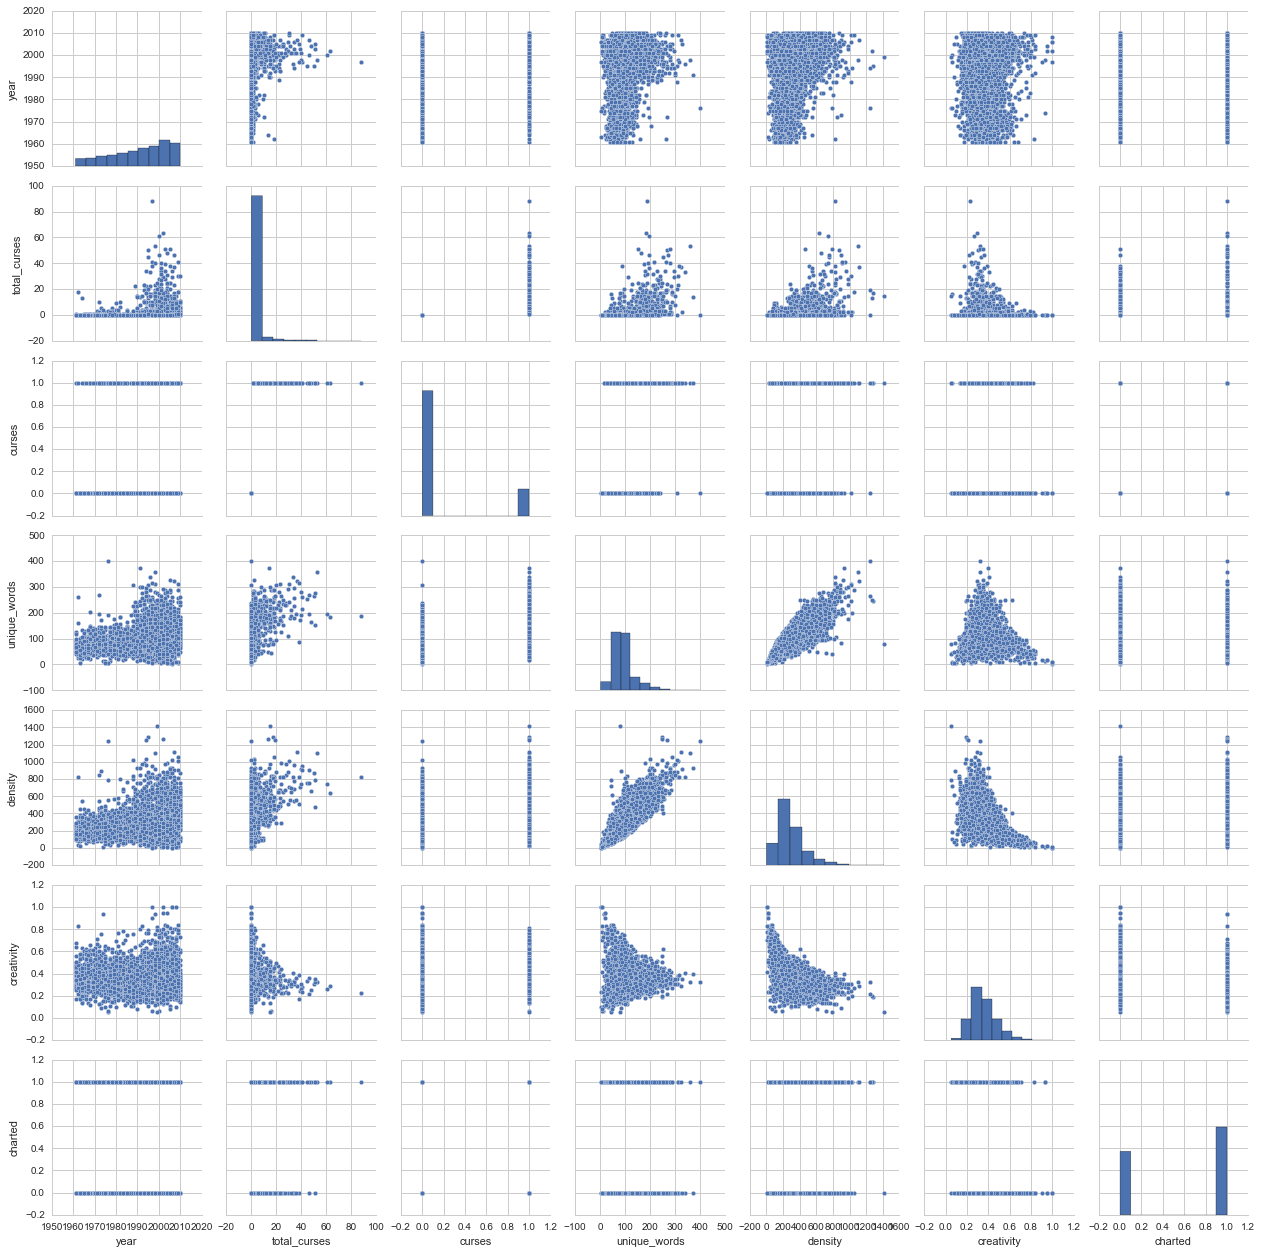

In [4]:
# Get pair plot for data
sns.pairplot(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9edf208390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9edee9cb50>]], dtype=object)

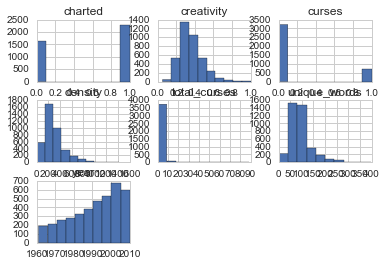

In [5]:
df.hist()

In [6]:
# Analyze unnormalized and normalized Charted by Curse Words

# Get group by counts for unnormalized charted by curses
df_by_sex_unnorm = pd.DataFrame()
df_by_sex_unnorm['curses'] = df[df['curses']==1]['charted'].value_counts()
df_by_sex_unnorm['no_curses'] = df[df['curses']==0]['charted'].value_counts()

In [7]:
# Get group by counts for normalized charted by curses
df_by_sex_normed = pd.DataFrame()
df_by_sex_normed['curses'] = df[df['curses']==1]['charted'].value_counts(normalize=True)
df_by_sex_normed['no_curses'] = df[df['curses']==0]['charted'].value_counts(normalize=True)

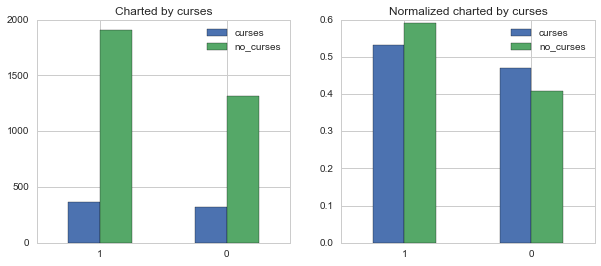

In [8]:
# Plot Unnormalized and Normalized Survival by Sex
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
df_by_sex_unnorm.plot(ax=ax1, kind='bar', rot=0, title="Charted by curses")
ax2 = fig.add_subplot(122)
df_by_sex_normed.plot(ax=ax2, kind='bar', rot=0, title="Normalized charted by curses")

In [9]:
# Check data types
print df.dtypes

year              int64
total_curses      int64
curses            int64
unique_words      int64
density           int64
creativity      float64
charted           int64
dtype: object


In [10]:
def pre_proc(df):
    # Create dummy variables for all non-numerical columns
    
    # Get dummy variables for charted
    df = df.join(pd.get_dummies(df['curses'], prefix='curses'))
    # Remove charted column
    df = df.drop(['curses'], axis=1)
    
    return df

In [11]:
# Apply pre_proc() to DF
df = pre_proc(df)

# Check cleaned data
df.head()

,year,total_curses,unique_words,density,creativity,charted,curses_0,curses_1
0,1994,1,79,250,0.316000,1,0.0,1.0
0,1994,1,79,250,0.316000,1,1.0,0.0
0,1969,0,74,226,0.327434,0,0.0,1.0
0,1969,0,74,226,0.327434,0,1.0,0.0
1,1975,0,73,255,0.286275,1,1.0,0.0


In [12]:
# Set target variable name
target = 'charted'

# Set X and y
X = df.drop([target], axis=1)
y = df[target]

In [13]:
# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [14]:
# Instantiate logistic regression classifier using default params
lm = linear_model.LogisticRegression()

# Train logistic regression classifier on training set
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
# Check model accuracy on test set
print "Accuracy: %0.3f" % lm.score(X_test, y_test)

Accuracy: 0.671


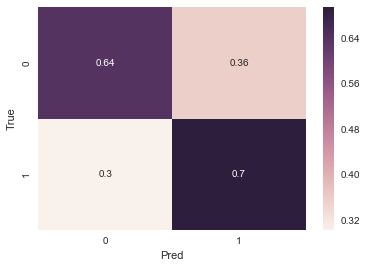

Confusion Matrix:
[[ 849  474]
 [ 470 1078]]


In [16]:
# Get confusion matrix on test set
y_pred = lm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

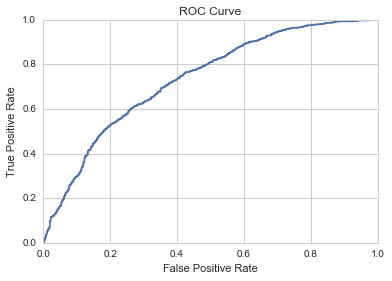

ROC AUC: 0.734


In [17]:
# Plot ROC curve and get AUC score
y_pred_proba = lm.predict_proba(X_test)[:,1]

# Determine the false positive and true positive rates
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba)

 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Get ROC AUC score
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, y_pred_proba)

In [18]:
# Set list of values to grid search over
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
s = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
params = {'C': c, 'solver':s}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

# Get improvement
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/sklearn/utils/optimize.py:200: UserWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best Params:
{'C': 1000, 'solver': 'newton-cg'}
Accuracy of current model: 0.671
Accuracy using best param: 0.795


In [19]:
# Current model params
print lm
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)

# Update model params
lm.set_params(C=1000)
lm.set_params(solver='newton-cg')

# Retrain model on new params
lm.fit(X_train, y_train)

# Updated model params
print lm
print "Accuracy of updated model: %0.3f" % lm.score(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of current model: 0.671
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of updated model: 0.793


In [20]:
# Load charted and uncharted dataset
charted = pd.read_csv("../db/analytics/charted.csv")

# Load charted and uncharted dataset
uncharted = pd.read_csv("../db/analytics/uncharted.csv")

df_train = pd.concat([charted, uncharted])
df_train.drop(df_train.columns[0:2], axis=1, inplace=True)
# Pre-process data
df_train = pre_proc(df_train)

df_train.head()

,year,total_curses,unique_words,density,creativity,charted,curses_0,curses_1
0,1994,1,79,250,0.316000,1,0.0,1.0
0,1994,1,79,250,0.316000,1,1.0,0.0
0,1969,0,74,226,0.327434,0,0.0,1.0
0,1969,0,74,226,0.327434,0,1.0,0.0
1,1975,0,73,255,0.286275,1,1.0,0.0


In [21]:
# Set target variable name
target = 'charted'

# Set X_train and y_train
X_train = df_train.drop([target], axis=1)
y_train = df_train[target]

In [22]:

# Build tuned model
lm = linear_model.LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

# Train tuned model
lm.fit(X_train, y_train)

# Score tuned model
print "Accuracy: %0.3f" % lm.score(X_train, y_train)

Accuracy: 0.794


In [23]:
# Generate probabililty of charted using trained model
df_train['Probability'] = lm.predict_proba(X_train)[:,1]

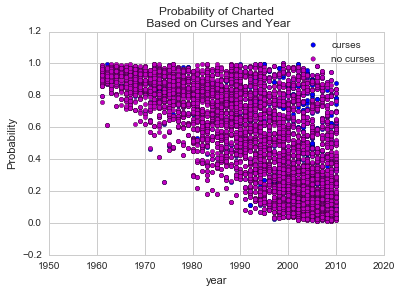

In [29]:
# Plot Probability of Survivial Based on Sex and Age
ax = df_train[df_train['curses_1']==1].plot(
    x='year', y='Probability', kind='scatter', color='b', label='curses'
)
df_train[df_train['curses_0']==1].plot(
    ax=ax, x='year', y='Probability', kind='scatter', color='m', label='no curses'
)
ax.set(title='Probability of Charted\n Based on Curses and Year')